# TabNet Module

## Import libraries

In [6]:
import itertools
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

## Setting device and seed

In [7]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower


SEED = 42
fix_random(SEED)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cuda


# TabNet

In [8]:
class TabNet(torch.nn.Module):
    '''
    Wrapper class for TabNetClassifier
    '''

    def __init__(self, n_d,
                 n_a,
                 n_steps,
                 gamma,
                 optimizer_fn,
                 n_independent,
                 n_shared,
                 epsilon,
                 seed,
                 lambda_sparse,
                 clip_value,
                 momentum,
                 optimizer_params,
                 scheduler_params,
                 mask_type,
                 scheduler_fn,
                 device_name,
                 output_dim,
                 batch_size,
                 num_epochs,
                 unsupervised_model,
                 cat_idxs=None,
                 cat_dims=None,
                 verbose=0):
        super(TabNet, self).__init__()

        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.unsupervised_model = unsupervised_model
        self.network = TabNetClassifier(n_d=n_d,
                                        n_a=n_a,
                                        n_steps=n_steps,
                                        gamma=gamma,
                                        optimizer_fn=optimizer_fn,
                                        n_independent=n_independent,
                                        n_shared=n_shared,
                                        epsilon=epsilon,
                                        seed=seed,
                                        lambda_sparse=lambda_sparse,
                                        clip_value=clip_value,
                                        momentum=momentum,
                                        optimizer_params=optimizer_params,
                                        scheduler_params=scheduler_params,
                                        mask_type=mask_type,
                                        scheduler_fn=scheduler_fn,
                                        device_name=device_name,
                                        output_dim=output_dim,
                                        verbose=verbose,
                                        cat_idxs=cat_idxs,
                                        cat_dims=cat_dims,
                                        cat_emb_dim=8
                                        )

    def fit_model(self, X_train, y_train, X_val, y_val, criterion):
        self.network.fit(X_train=X_train,
                         y_train=y_train,
                         eval_set=[(X_train, y_train), (X_val, y_val)],
                         eval_metric=['balanced_accuracy'],
                         patience=10,
                         batch_size=self.batch_size,
                         virtual_batch_size=128,
                         num_workers=0,
                         drop_last=True,
                         max_epochs=self.num_epochs,
                         loss_fn=criterion,
                         from_unsupervised=self.unsupervised_model)

    def predict(self, X):
        return self.network.predict(X)

    def explain(self, X):
        return self.network.explain(X)

    def feature_importances(self):
        return self.network.feature_importances_


def get_unsupervised_model(n_d_a, n_step, n_independent, n_shared, gamma, lr, cat_idxs=None, cat_dims=None):
    tabnet_params = dict(n_d=n_d_a,
                         n_a=n_d_a,
                         n_steps=n_step,
                         gamma=gamma,
                         n_independent=n_independent,
                         n_shared=n_shared,
                         lambda_sparse=1e-3,
                         optimizer_fn=torch.optim.AdamW,
                         optimizer_params=dict(lr=lr),
                         mask_type="sparsemax",
                         verbose=1,
                         cat_idxs=cat_idxs,
                         cat_dims=cat_dims,
                         cat_emb_dim=8
                         )
    return TabNetPretrainer(**tabnet_params)

## Load the dataset

In [9]:
filepath = "."

FILENAME = "dataset/train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, sep=",", low_memory=False)

# Extract relevant features excluding specified columns
features_to_retain = df1.columns.difference(["label", "ts", "type", "http_referrer"]).tolist()
df1 = df1[features_to_retain + ["type"]]

print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))

# Converte i valori in numeri, sostituendo quelli non validi con NaN
df1["src_bytes"] = pd.to_numeric(df1["src_bytes"], errors='coerce')
# Filtra le righe con NaN (valori non convertibili)
df1 = df1.dropna(subset=["src_bytes"])
# Converte i valori rimasti in interi
df1.loc[:, "src_bytes"] = df1["src_bytes"].astype(int)

df1 = df1.dropna()
print("Dopo drop NaN")
print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))

features = df1.columns.difference(["type"]).tolist()
X = df1[features]
y = df1["type"]

with open(f"{filepath}/transformer/target_encoder.save", "rb") as f:
    le: preprocessing.LabelEncoder = pickle.load(f)

y = le.transform(y)

# Separate indices
indices = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=SEED)

# Take only X with index in val_idx
X_val = X.iloc[val_idx]
y_val = y[val_idx]

# Take only X with index in train_idx
X_train = X.iloc[train_idx]
y_train = y[train_idx]

#Righe: 617002 #Colonne: 43
Dopo drop NaN
#Righe: 616983 #Colonne: 43


## Preprocessing

In [10]:
categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()


class CustomOrdinalEncoder(OrdinalEncoder):
    def transform(self, X):
        encoded = super().transform(X)
        # Shift all values by +1 and replace unknown_value (-1) with 0
        return np.where(encoded == -1, 0, encoded + 1)

    def inverse_transform(self, X):
        # Handle the inverse transform to account for the +1 offset
        X = np.where(X == 0, -1, X - 1)
        return super().inverse_transform(X)


def preprocess(X_train, X_val, save=False):
    ct = ColumnTransformer(
        [
            ("cat", CustomOrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),  # Trasforma le colonne categoriche
            ("scale", StandardScaler(), numeric_columns)  # Normalizza le colonne numeriche
        ],
        remainder="passthrough"  # Mantieni le altre colonne invariate
    )
    ct.set_output(transform="pandas")

    ct = ct.fit(X_train)
    if save:
        with open(f"{filepath}/transformer/transformer_tb.save", "wb") as f:
            pickle.dump(ct, f)

    # train set
    X_train = ct.transform(X_train)
    cat_idxs = [i for i, f in enumerate(X_train.columns) if "cat__" in f]
    cat_dims = [len(X_train[f].unique()) + 1 for i, f in enumerate(X_train.columns) if "cat__" in f]

    # validation set
    X_val = ct.transform(X_val)

    return X_train, X_val, cat_idxs, cat_dims


def evaluate_model(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    return {"acc": acc, "bacc": bacc, "f1": f1}

## Cross-validation and hyperparameter tuning

### Hyperparameters configuration

In [6]:
nums_epochs = [1000]
batch_sizes = [1024]
patience = [20]
n_d_a = [8, 32, 64]
n_shared = [1, 3, 5]
n_indipendents = [1, 3, 5]
n_steps = [2, 4, 8, 10]
gamma = [1.1, 1.5, 2.0]
epsilon = [1e-15]
learning_rate = [0.001]
pretraining_ratio = [0.5]
momentum = [0.02]
hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, n_d_a, n_indipendents, n_shared, n_steps, gamma, epsilon, learning_rate, pretraining_ratio, momentum))
n_comb = len(hyperparameters)
print(f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 324


## Hyperparameter tuning

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

current_iter = 0
best_bacc = 0

for num_epochs, batch_size, patience_, n_d, n_i, n_s, n_steps_, gamma_, epsilon_, lr, pretraining_ratio_, moment in hyperparameters:
    print(f'Iteration {current_iter + 1}/{n_comb}')
    print(f'Hyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, patience={patience_}, n_d={n_d}, n_indipendent={n_i}, n_shared={n_s}, n_steps={n_steps_}, gamma={gamma_}, epsilon={epsilon_}, lr={lr}, pretraining_ratio={pretraining_ratio_}, momentum={moment}')

    accuracy_per_fold = []
    balanced_accuracy_score_per_fold = []
    f1_score_per_fold = []
    fold = 0
    for train_index, val_index in skf.split(X_train, y_train):
        # Split the data into training and validation sets for the current fold
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Preprocess the data
        X_train_fold, X_val_fold, cat_idxs_fold, cat_dims_fold = preprocess(X_train_fold, X_val_fold)

        # Ensure the number of classes is correctly identified
        num_classes = len(np.unique(y_train))

        # Compute class weights for the current fold
        class_weights_fold = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_fold), y=y_train_fold)
        class_weights_fold = dict(enumerate(class_weights_fold))

        # Define the loss function with the correct class weights
        criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_fold.values()), dtype=torch.float32).to(device))

        model = TabNet(n_d=n_d,
                       n_a=n_d,
                       n_steps=n_steps_,
                       gamma=gamma_,
                       optimizer_fn=torch.optim.AdamW,
                       n_independent=n_i,
                       n_shared=n_s,
                       epsilon=epsilon_,
                       seed=SEED,
                       lambda_sparse=1e-4,
                       clip_value=1,
                       momentum=moment,
                       optimizer_params=dict(lr=lr),
                       scheduler_params=dict(step_size=10, gamma=0.9),
                       mask_type='sparsemax',
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       device_name=device,
                       output_dim=len(np.unique(y_train)),
                       batch_size=batch_size,
                       num_epochs=num_epochs,
                       unsupervised_model=None,
                       verbose=1,
                       cat_idxs=cat_idxs_fold,
                       cat_dims=cat_dims_fold)

        model.fit_model(X_train_fold.values, y_train_fold, X_val_fold.values, y_val_fold, criterion)
        y_pred_fold = model.predict(X_val_fold.values)

        perf = evaluate_model(y_val_fold, y_pred_fold)

        # Store performance metrics for the current fold
        accuracy_per_fold.append(perf["acc"])
        balanced_accuracy_score_per_fold.append(perf["bacc"])
        f1_score_per_fold.append(perf["f1"])

        print(f"Fold {fold} - Accuracy: {perf['acc']:.2f}%")
        print(f"Fold {fold} - Balanced Accuracy: {perf['bacc']:.2f}%")
        print(f"Fold {fold} - F1 Score: {perf['f1']:.2f}%")

        fold += 1

    avg_bacc = np.mean(balanced_accuracy_score_per_fold)
    # Print cross-validation results
    print("Cross-Validation Results:")
    print(f"Average Accuracy: {np.mean(accuracy_per_fold) * 100:.2f}%")
    print(f"Standard Deviation of Accuracy: {np.std(accuracy_per_fold) * 100:.2f}%")
    print(f"Average Balanced Accuracy: {avg_bacc * 100:.2f}%")
    print(f"Standard Deviation of Balanced Accuracy: {np.std(balanced_accuracy_score_per_fold) * 100:.2f}%")
    print(f"Average F1 Score: {np.mean(f1_score_per_fold) * 100:.2f}%")
    print(f"Standard Deviation of F1 Score: {np.std(f1_score_per_fold) * 100:.2f}%")

    if avg_bacc > best_bacc:
        best_acc = avg_bacc
        best_hyperparameters = f"num_epochs={num_epochs}, batch_size={batch_size}, patience={patience_}, n_d={n_d}, n_indipendent={n_i}, n_shared={n_s}, n_steps={n_steps_}, gamma={gamma_}, epsilon={epsilon_}, lr={lr}, pretraining_ratio={pretraining_ratio_}, momentum={moment}"
    current_iter += 1

Iteration 1/324
Hyperparameters: num_epochs=1000, batch_size=1024, patience=20, n_d=8, n_indipendent=1, n_shared=1, n_steps=2, gamma=1.1, epsilon=1e-15, lr=0.001, pretraining_ratio=0.5, momentum=0.02


C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.57132 | val_0_balanced_accuracy: 0.45315 | val_1_balanced_accuracy: 0.45679 |  0:00:44s


KeyboardInterrupt: 

## Training best model

#### Define weights for unbalanced classes

In [6]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 4.069469865611345, 1: 0.3381003918130257, 2: 1.132545546326465, 3: 4.543735616312253, 4: 98.7172, 5: 2.9863625363020327, 6: 1.1966881637007225, 7: 63.85329883570505, 8: 0.28803534018428717, 9: 0.9751965859248429}


#### Train

In [7]:
nums_epochs = 1000
batch_sizes = 1024
patience = 20
n_d_a = 8
n_shared = 5
n_indipendents = 3
n_steps = 8
gamma = 2.0
epsilon = 1e-15
learning_rate = 0.001
pretraining_ratio = 0.5
momentum = 0.02

X_train, X_val, cat_idxs, cat_dims = preprocess(X_train, X_val, save=True)

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))

unsupervised_model = get_unsupervised_model(n_d_a=64, n_step=8, n_independent=1, n_shared=1, gamma=1.1, lr=0.001, cat_idxs=cat_idxs, cat_dims=cat_dims)

unsupervised_model.fit(
    X_train=X_train.values,
    eval_set=[X_val.values],
    max_epochs=1000,
    patience=20,
    batch_size=1024*20,
    virtual_batch_size=128*20,
    drop_last=False,
    num_workers=0,
    pretraining_ratio=0.5,
)

best_model = TabNet(n_d=n_d_a,
                    n_a=n_d_a,
                    n_steps=n_steps,
                    gamma=gamma,
                    optimizer_fn=torch.optim.AdamW,
                    n_independent=n_indipendents,
                    n_shared=n_shared,
                    epsilon=epsilon,
                    seed=SEED,
                    lambda_sparse=1e-4,
                    clip_value=1,
                    momentum=momentum,
                    optimizer_params=dict(lr=learning_rate),
                    scheduler_params=dict(step_size=10, gamma=0.9),
                    mask_type='sparsemax',
                    scheduler_fn=torch.optim.lr_scheduler.StepLR,
                    device_name=device,
                    output_dim=len(np.unique(y_train)),
                    batch_size=batch_sizes,
                    num_epochs=nums_epochs,
                    unsupervised_model=unsupervised_model,
                    verbose=1,
                    cat_idxs=cat_idxs,
                    cat_dims=cat_dims)

best_model.fit_model(X_train.values, y_train, X_val.values, y_val, criterion)
with open(f"{filepath}/models/tb.save", "wb") as f:
    pickle.dump(best_model, f)

y_pred = best_model.predict(X_val.values)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'Balanced accuracy: {balanced_accuracy_score(y_val, y_pred)}')
print(f'F1 score: {f1_score(y_val, y_pred, average="weighted")}')

C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 46519280.53405| val_0_unsup_loss_numpy: 261948.421875|  0:00:14s
epoch 1  | loss: 6814364.36075| val_0_unsup_loss_numpy: 331895.46875|  0:00:28s
epoch 2  | loss: 4283787.75281| val_0_unsup_loss_numpy: 596079.3125|  0:00:42s
epoch 3  | loss: 1294591.22743| val_0_unsup_loss_numpy: 112889.9921875|  0:00:57s
epoch 4  | loss: 1578480.37755| val_0_unsup_loss_numpy: 464156.09375|  0:01:11s
epoch 5  | loss: 2369355.64049| val_0_unsup_loss_numpy: 226268.03125|  0:01:25s
epoch 6  | loss: 101180.17159| val_0_unsup_loss_numpy: 180204.109375|  0:01:40s
epoch 7  | loss: 1509080.32729| val_0_unsup_loss_numpy: 65336.21875|  0:01:55s
epoch 8  | loss: 4100524.84026| val_0_unsup_loss_numpy: 74331.921875|  0:02:09s
epoch 9  | loss: 110800.58687| val_0_unsup_loss_numpy: 147342.3125|  0:02:23s
epoch 10 | loss: 1181746.70971| val_0_unsup_loss_numpy: 112943.828125|  0:02:37s
epoch 11 | loss: 21914.06643| val_0_unsup_loss_numpy: 58297.875|  0:02:51s
epoch 12 | loss: 1763328.59119| val_0_unsup_

C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 8 to 64
  warnings.warn(wrn_msg)
C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 8 to 64
  warnings.warn(wrn_msg)
C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_independent changed from 3 to 1
  warnings.warn(wrn_msg)
C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\si

epoch 0  | loss: 2.15697 | val_0_balanced_accuracy: 0.56362 | val_1_balanced_accuracy: 0.55774 |  0:02:01s
epoch 1  | loss: 0.97506 | val_0_balanced_accuracy: 0.68705 | val_1_balanced_accuracy: 0.68419 |  0:03:57s
epoch 2  | loss: 0.6069  | val_0_balanced_accuracy: 0.73291 | val_1_balanced_accuracy: 0.73596 |  0:05:52s
epoch 3  | loss: 0.42142 | val_0_balanced_accuracy: 0.83497 | val_1_balanced_accuracy: 0.84122 |  0:07:52s
epoch 4  | loss: 0.29135 | val_0_balanced_accuracy: 0.87706 | val_1_balanced_accuracy: 0.87525 |  0:09:49s
epoch 5  | loss: 0.20849 | val_0_balanced_accuracy: 0.9024  | val_1_balanced_accuracy: 0.8975  |  0:11:45s
epoch 6  | loss: 0.16677 | val_0_balanced_accuracy: 0.92445 | val_1_balanced_accuracy: 0.92042 |  0:13:43s
epoch 7  | loss: 0.13931 | val_0_balanced_accuracy: 0.92778 | val_1_balanced_accuracy: 0.9251  |  0:15:38s
epoch 8  | loss: 0.12487 | val_0_balanced_accuracy: 0.92362 | val_1_balanced_accuracy: 0.92091 |  0:17:33s
epoch 9  | loss: 0.11979 | val_0_bala

C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.9729896188724199
Balanced accuracy: 0.9565912244563
F1 score: 0.9734339025682367


## Explainability

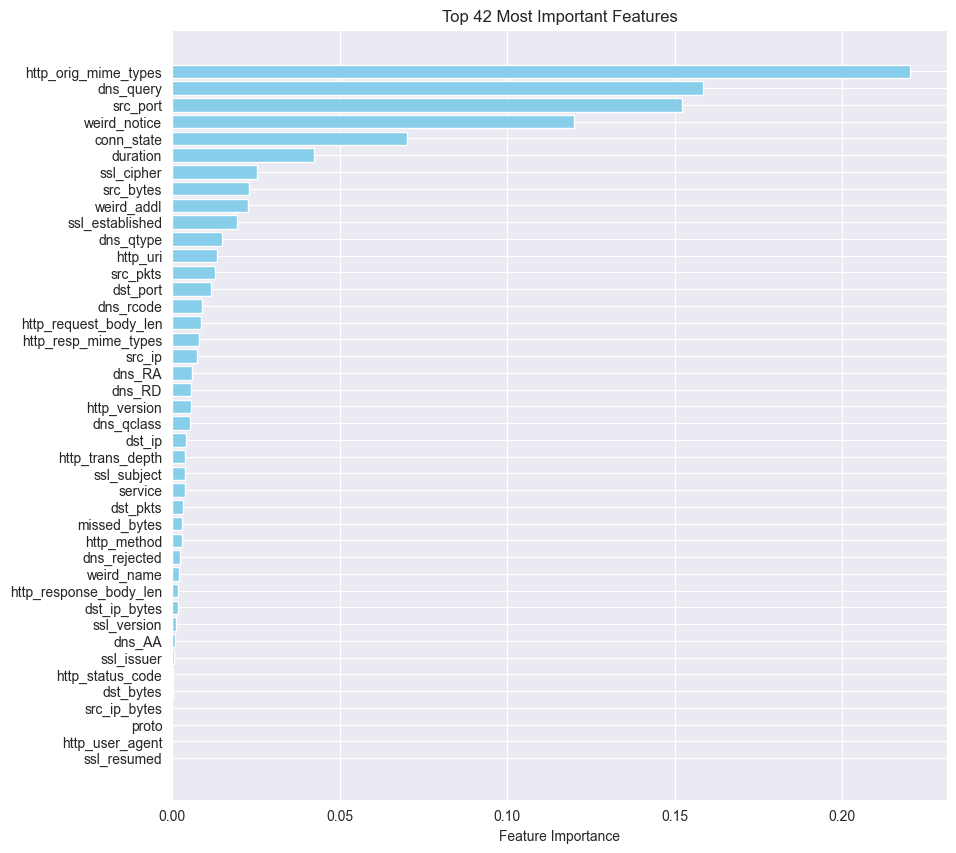

In [13]:
with open(f"{filepath}/models/tb.save", "rb") as f:
    best_model = pickle.load(f)



# Assuming `feature_importances` is a numpy array containing the importance values
# and `feature_names` is a list of names corresponding to the features
feature_importances = best_model.network.feature_importances_
feature_names = df1.drop(columns=['type']).columns

n_features = len(df1.columns) -1
# Sort the feature importances in descending order and select the top 10
indices = np.argsort(feature_importances)[-n_features:][::-1]
top_features = feature_importances[indices]
top_feature_names = feature_names[indices]

# Plotting
plt.figure(figsize=(10, 10))
plt.barh(top_feature_names, top_features, color='skyblue')
plt.xlabel("Feature Importance")
plt.title(f"Top {n_features} Most Important Features")
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()

### Plot

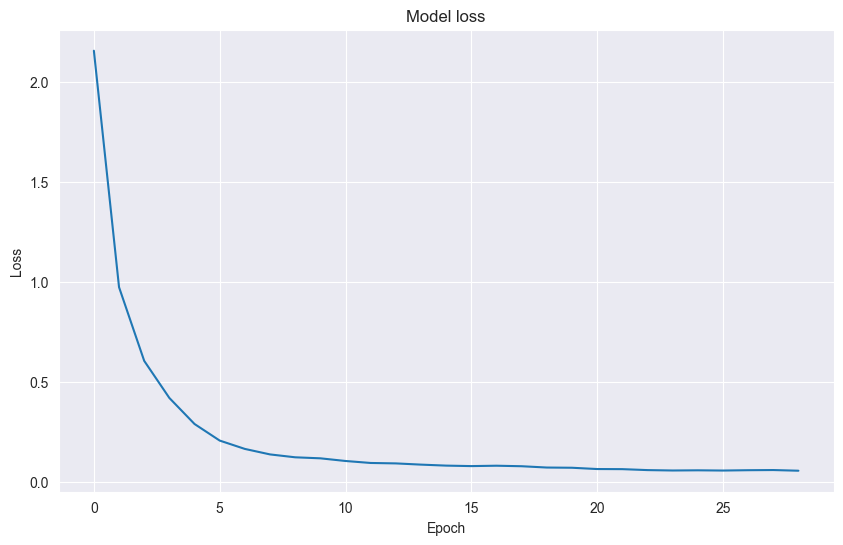

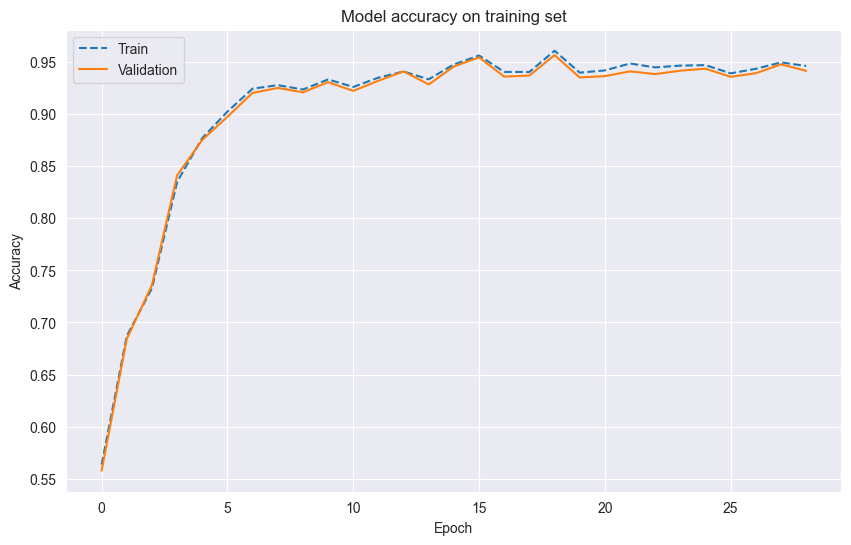

In [18]:
history = best_model.network.history

plt.figure(figsize=(10, 6))
plt.plot(history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history['val_0_balanced_accuracy'], linestyle='--')
plt.plot(history['val_1_balanced_accuracy'])
plt.title('Model accuracy on training set')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()